# Universal Differential Equation for a 2D PDE heat equation

In [1]:
using Pkg; Pkg.activate("../../."); Pkg.instantiate()
using Plots; gr()
using Statistics
using LinearAlgebra
using Zygote
using PaddedViews
using Flux
using Flux: @epochs
using Tullio

  Activating environment at `~/Desktop/Jordi/Julia/odinn_toy_model/Project.toml`


### Parameter declaration

In [2]:
nx, ny = 100, 100 # Size of the grid
Δx, Δy = 1, 1
Δt = 0.1
t₁ = 5

#D₀ = 1
tolnl = 1e-4
itMax = 20
damp = 0.85
dτsc   = 1.0/3.0
ϵ     = 1e-4            # small number
cfl  = max(Δx^2,Δy^2)/4.1;

ref_steps = [1.5, 3.5] # intermediate time steps to be saved for the loss function

2-element Vector{Float64}:
 1.5
 3.5

In [3]:
function heatflow(T, fD::Function, p, tol=1e-4)
   
    Δx, Δy, Δt, t₁, ref_steps = p
    
    total_iter = 0
    t = 0
    step_idx = 1
    T_steps = []
    
    while t < t₁
        
        iter = 1
        err = 2 * tolnl
        Hold = copy(T)
        dTdt = zeros(nx, ny)
        err = Inf 
        
        while iter < itMax+1 && tol <= err
            
            Err = copy(T)
                    
            D = fD(t)  # compute the diffusivity at each time
            # if iter == 1
            #     println("current D: ", D)
            # end
            
            F, dτ = Heat(T, D, p)
            
            @tullio ResT[i,j] := -(T[i,j] - Hold[i,j])/Δt + F[pad(i-1,1,1),pad(j-1,1,1)] 
            
            dTdt_ = copy(dTdt)
            @tullio dTdt[i,j] := dTdt_[i,j]*damp + ResT[i,j]
            
            T_ = copy(T)
            #@tullio T[i,j] := max(0.0, T_[i,j] + dTdt[i,j]*dτ[pad(i-1,1,1),pad(j-1,1,1)]) 
            @tullio T[i,j] := max(0.0, T_[i,j] + dτ * dTdt[i,j])
            
            Zygote.ignore() do
                Err .= Err .- T
                err = maximum(Err)
            end 
            
            iter += 1
            total_iter += 1
            
        end

        # We store the temperature matrix for the required time steps
        if(step_idx <= length(ref_steps))
            if(t >= ref_steps[step_idx])
                push!(T_steps, T)
                step_idx += 1
            end
        end
        
        t += Δt
        
    end

    # We always store the final time step
    push!(T_steps, T)
    
    return T_steps
    
end

heatflow (generic function with 2 methods)

In [4]:
function Heat(T, D, p)
   
    Δx, Δy, Δt, t₁ = p
    
    #dTdx = diff(S, dims=1) / Δx
    #dTdy = diff(S, dims=2) / Δy

    dTdx_edges = diff(T[:,2:end - 1], dims=1) / Δx
    dTdy_edges = diff(T[2:end - 1,:], dims=2) / Δy
    
    Fx = -D * dTdx_edges
    Fy = -D * dTdy_edges    
    F = .-(diff(Fx, dims=1) / Δx .+ diff(Fy, dims=2) / Δy) 

    dτ = dτsc * min( 10.0 , 1.0/(1.0/Δt + 1.0/(cfl/(ϵ + D))))
    
    return F, dτ
 
end

Heat (generic function with 1 method)

## Creating a reference dataset with a fake law

Let's assume that $D$ is a function of time

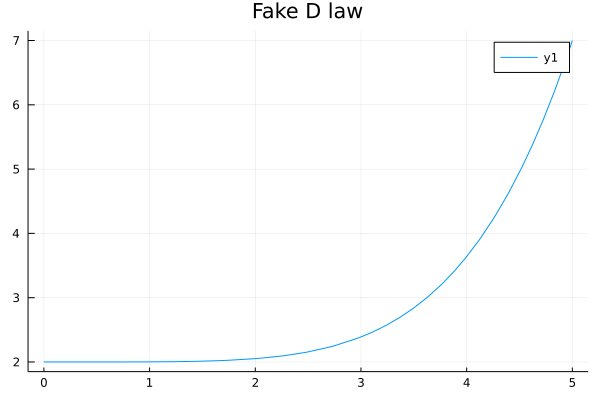

In [5]:
D_max = 10
D_min = 0

fakeD(t) = 1 * (2 + t^5 / t₁^4)

plot(fakeD, 0, t₁, title="Fake D law")

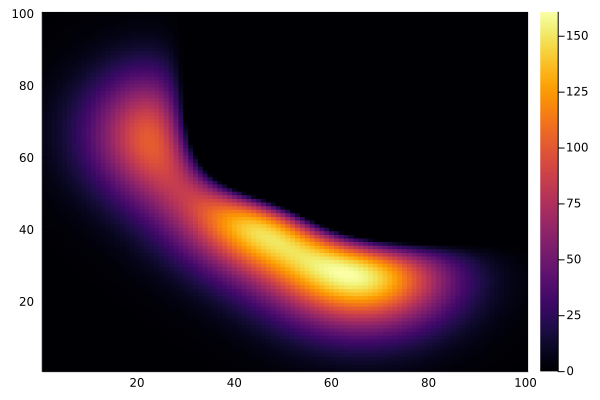

In [6]:
function truncated_gaussian(i₀, j₀, off) 
    
    M = [ 250 * exp( - ( (i - i₀)^2 + (j - j₀)^2 ) / 300 ) - off for i in 1:nx, j in 1:ny ]
    max.(0., M)
    
end

#T₀ = [ 250 * exp( - ( (i - nx/2)^2 + (j - ny/2)^2 ) / 300 ) for i in 1:nx, j in 1:ny ]

#T₀ = [ -(i - nx/2)^2 - (j - ny/.6)^2 + 40000 for i in 1:nx, j in 1:ny ]
#T₀ = max.(0., T₀)

T₀ = 1.5 * truncated_gaussian(nx/2, ny/2, 0) + 
     1 * truncated_gaussian(nx/3, ny/1.5, 0) +
     1 * truncated_gaussian(nx/1.5, ny/3, 0) - 
     4 * truncated_gaussian(nx/1.5, ny/2, 0) - 
     2 * truncated_gaussian(nx/2, ny/1.5, 0)

T₀ = max.(0., T₀)

heatmap(T₀, clim=(0, maximum(T₀)))

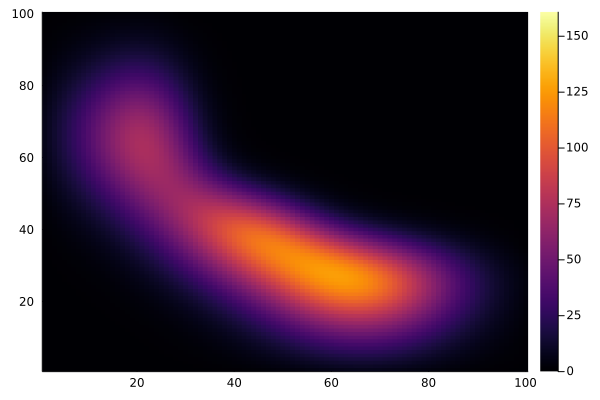

In [7]:
p = (Δx, Δy, Δt, t₁, ref_steps)

T₁ = copy(T₀)
T_steps_ref = heatflow(T₁, fakeD, p, 1e-2)
T₁ = T_steps_ref[end]

heatmap(T₁, clim=(0, maximum(T₀)))

In [8]:
sqrt( sum((T₁.-T₀).^2) / (nx * ny) )

10.095895612117783

## Using a neural network to learn D

Now, let's try to reproduce `fakeD()` with a NN.

In [9]:
function heatflow_NN(T, uD, p, tol=1e-4)
   
    Δx, Δy, Δt, t₁, ref_steps = p
    
    total_iter = 0
    t = 0
    step_idx = 1
    T_steps = Zygote.Buffer([])
    
    while t < t₁
        
        iter = 1
        err = 2 * tolnl
        Hold = copy(T)
        dTdt = zeros(nx, ny)
        err = Inf 
        
        while iter < itMax+1 && tol <= err
            
            Err = copy(T)
                    
            D = uD([t]')[1]  # compute the diffusivity at each time
            #println(D)
            F, dτ = Heat(T, D, p)
            
            @tullio ResT[i,j] := -(T[i,j] - Hold[i,j])/Δt + F[pad(i-1,1,1),pad(j-1,1,1)] 
            
            dTdt_ = copy(dTdt)
            @tullio dTdt[i,j] := dTdt_[i,j]*damp + ResT[i,j]
            
            T_ = copy(T)
            #@tullio T[i,j] := max(0.0, T_[i,j] + dTdt[i,j]*dτ[pad(i-1,1,1),pad(j-1,1,1)]) 
            @tullio T[i,j] := max(0.0, T_[i,j] + dτ * dTdt[i,j])
            
            Zygote.ignore() do
                Err .= Err .- T
                err = maximum(Err)
            end 
            
            iter += 1
            total_iter += 1
            
        end

        # We store the temperature matrix for the required time steps
        if(step_idx <= length(ref_steps))
            if(t >= ref_steps[step_idx])
                push!(T_steps, T)
                step_idx += 1
            end
        end
        
        t += Δt
        
    end

    # We always store the final time step
    push!(T_steps, T)
    
    return T_steps
    
end

heatflow_NN (generic function with 2 methods)

In [10]:
sqnorm(x) = sum(abs2, x)

function loss(T, UD, p, λ=1)

    T_steps = heatflow_NN(T, UD, p)
    l_cost = 0
    for (i, T) in enumerate(T_steps)
        l_cost += sqrt(Flux.Losses.mse(T, T_steps_ref[i]; agg=mean))
    end
    l_cost /= length(T_steps)
    #l_reg  = sum(sqnorm, ps)

    return l_cost #+ λ * l_reg
end

loss (generic function with 2 methods)

In [39]:
# Patch suggested by Michael Abbott needed in order to correctly retrieve gradients
Flux.Optimise.update!(opt, x::AbstractMatrix, Δ::AbstractVector) = Flux.Optimise.update!(opt, x, reshape(Δ, size(x)))

leakyrelu(x, a=0.01) = max(a*x, x)
relu(x) = max(0, x)
sigmoid_D(x) = .5 + 10 / ( 1 + exp(-x) ) 

function train(loss, p)

    # UD = Chain(
    #     Dense(1,10, initb=Flux.glorot_normal), 
    #     BatchNorm(10, ),
    #     Dense(10, 5, x->tanh.(x), initb =Flux.glorot_normal), 
    #     BatchNorm(5, ),
    #     Dense(5, 5, x->tanh.(x), initb=Flux.glorot_normal),
    #     BatchNorm(5, ),
    #     Dense(5,1, relu, initb = Flux.glorot_normal) 
    # )


    # UD = Chain(
    #     Dense(1,10, initb=Flux.glorot_normal), 
    #     BatchNorm(10, ),
    #     Dense(10, 5, leakyrelu, initb =Flux.glorot_normal), 
    #     BatchNorm(5, ),
    #     Dense(5, 5, leakyrelu, initb=Flux.glorot_normal),
    #     BatchNorm(5, ),
    #     Dense(5,1, relu, initb = Flux.glorot_normal) 
    # )
    
    UD = Chain(
       Dense(1,5,initb = Flux.glorot_uniform), 
       BatchNorm(5, ),
       Dense(5, 10, x->tanh.(x), initb = Flux.glorot_uniform),
       BatchNorm(10, ),
       Dense(10, 5, x->tanh.(x), initb = Flux.glorot_uniform),
       BatchNorm(5, ),
       Dense(5, 1)
    )
    
    
    # opt = ADAM(1.0e-3)
    opt = RMSProp(0.1)
    #opt = Descent(0.1)
    
    losses = []
    θ = Flux.params(UD)
    @epochs 5 hybrid_train!(loss, UD, θ, p, opt, losses)
    
    return UD, θ, losses
    
end

function hybrid_train!(loss, UD, θ, p, opt, losses)
    
    T = T₀
    loss_uD, back_uD = Zygote.pullback(() -> loss(T, UD, p), θ)
    push!(losses, loss_uD)
    
    println("Current loss: ", loss_uD)
    # println("Current parameter:", θ)
    ∇_uD = back_uD(one(loss_uD))

    # for p in θ
    #    println("Gradients ∇_uD[p]: ", ∇_uD[p])
    # end
    
    #println("Values of NN: ", UD([0., .5, 1.]'))
    #all_times = LinRange(0, t₁, 1000)
    #plot(all_times, UD(all_times')')

    # Zygote.ignore() do
    #     all_times = LinRange(0, t₁, 1000)
    #     println("UD(all_times')': ",  UD(all_times')')
    #     plot(all_times, UD(all_times')', title="Simulated D values by the NN", yaxis="Diffusivity (D)", xaxis="Time", label="NN")
    #     display(plot!(fakeD, 0, t₁, label="fake"))
    # end
    
    Flux.Optimise.update!(opt, θ, ∇_uD)
    
    
end

hybrid_train! (generic function with 1 method)

In [40]:
UD_trained, θ, losses = train(loss, p)

┌ Info: Epoch 1
└ @ Main /Users/Bolib001/.julia/packages/Flux/ma5BY/src/optimise/train.jl:138


Current loss: 7.055154100937571


┌ Info: Epoch 2
└ @ Main /Users/Bolib001/.julia/packages/Flux/ma5BY/src/optimise/train.jl:138


Current loss: 6.734885001370093


┌ Info: Epoch 3
└ @ Main /Users/Bolib001/.julia/packages/Flux/ma5BY/src/optimise/train.jl:138


Current loss: 6.419162113777346


┌ Info: Epoch 4
└ @ Main /Users/Bolib001/.julia/packages/Flux/ma5BY/src/optimise/train.jl:138


Current loss: 6.150204540169857


┌ Info: Epoch 5
└ @ Main /Users/Bolib001/.julia/packages/Flux/ma5BY/src/optimise/train.jl:138


Current loss: 5.89509779532429


(Chain(Dense(1, 5), BatchNorm(5), Dense(5, 10, #138), BatchNorm(10), Dense(10, 5, #139), BatchNorm(5), Dense(5, 1)), Params([Float32[-0.1609273; 0.30506396; … ; 0.26235962; -0.388633], Float32[0.40070558, 0.35778546, -0.61184454, 0.8860278, -0.8163476], Float32[0.0, 0.0, 0.0, 0.0, 0.0], Float32[1.0, 1.0, 1.0, 1.0, 1.0], Float32[-0.028797109 0.18558645 … -0.44331634 0.33098987; -0.21581893 -0.24594781 … 0.111761 0.3067772; … ; -0.13379914 -0.06463923 … -0.49932936 0.4181273; -0.11882411 0.1164997 … -0.42657557 -0.32829437], Float32[-0.33657202, 0.05213559, -0.13544858, 0.3464975, 0.12581751, 0.05483707, 0.13002697, 0.052302696, 0.3507177, -0.014857598], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], Float32[0.44701955 -0.30679062 … 0.24475476 -0.32367387; -0.5595883 -0.6209761 … 0.16898729 0.531378; … ; 0.047356237 0.5489731 … 0.32559976 -0.3449905; 0.4984189 -0.19630289 … 0.51159364 -0.5502486], Float32[-0.4037149, 

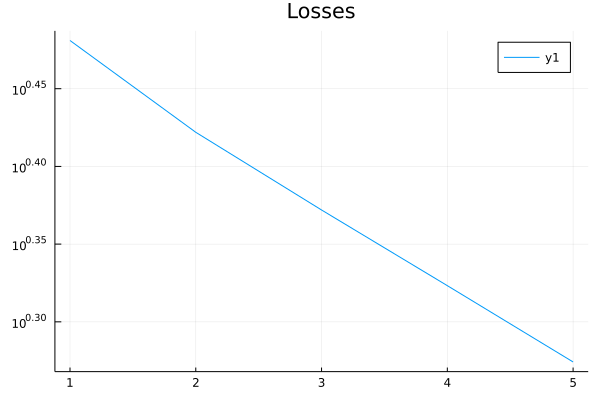

In [30]:
plot(losses, yaxis=:log, title="Losses")

In [14]:
println("θ: ", θ)
θ = Flux.params(UD_trained)
println("θ = Flux.params(UD_trained): ", θ)

θ: Params([Float32[0.30917168; 0.3377676; 0.3544116; 0.67016363; 0.48594427], Float32[-0.42909798, -0.6728729, -0.4174363, 0.12786491, -0.6631935], Float32[0.0, 0.0, 0.0, 0.0, 0.0], Float32[1.0, 1.0, 1.0, 1.0, 1.0], Float32[0.5775829 0.018974703 0.42202383 0.5573481 0.19920875; 0.04700505 0.1925012 0.48475197 -0.62863636 -0.06711309; -0.18340032 -0.0698401 -0.23638174 -0.022600127 -0.04198558; -0.51986426 0.38195252 -0.24719529 0.33537948 -0.15499768; 0.31677452 0.17802347 -0.61765254 0.29199052 -0.32793322; 0.16863866 -0.32565677 0.2778471 -0.10545107 -0.2953335; -0.18617454 -0.5323523 0.47603515 -0.52033323 0.2106054; -0.19989997 0.28540298 -0.3995763 -0.35806194 -0.48882404; 0.36013892 0.22672868 -0.4055658 -0.12870924 -0.42925447; -0.06367992 -0.57967347 0.06785029 0.16959497 -0.37092307], Float32[-0.3918237, 0.30213463, 0.5819713, 0.55356294, 0.018386494, 0.8289047, 0.5746788, 0.0026794889, 0.10748541, 0.0039327936], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float

UD(all_times')': [NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; NaN; Na

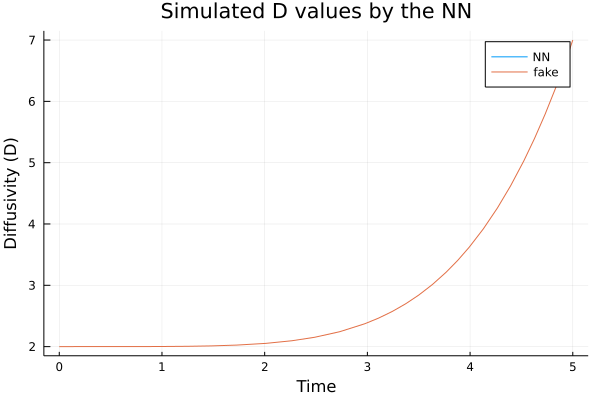

In [36]:
all_times = LinRange(0, t₁, 1000)
println("UD(all_times')': ",  UD_trained(all_times')')
plot(all_times, UD_trained(all_times')', title="Simulated D values by the NN", yaxis="Diffusivity (D)", xaxis="Time", label="NN")
plot!(fakeD, 0, t₁, label="fake")